<h2 align=center> Classify Radio Signals from Outer Space with Keras</h2>

![](Allen_Telescope.jpg)
[Allen Telescope Array](https://flickr.com/photos/93452909@N00/5656086917) by [brewbooks](https://www.flickr.com/people/93452909@N00) is licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/)

##  Import Libraries

In [2]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


##  Load and Preprocess SETI Data

In [10]:
train_images = pd.read_csv('dataset/train/images.csv',header=None)
train_labels = pd.read_csv('dataset/train/labels.csv',header=None)
validation_images = pd.read_csv('dataset/validation/images.csv',header=None)
validation_labels = pd.read_csv('dataset/validation/labels.csv',header=None)

In [11]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [12]:
train_labels.head()
#0 == squigle
#1 == narrow band
#2 == nOise
#3 == narrow band drd

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [13]:
train_images.shape

(3200, 8192)

In [14]:
train_labels.shape

(3200, 4)

In [15]:
validation_images.shape

(800, 8192)

In [16]:
validation_labels.shape

(800, 4)

In [17]:
x_train = train_images.values.reshape(3200,64,128,1)

In [18]:
x_val = validation_images.values.reshape(800,64,128,1)

In [19]:
y_train = train_labels.values
y_val = validation_labels.values

## 2D Spectrograms

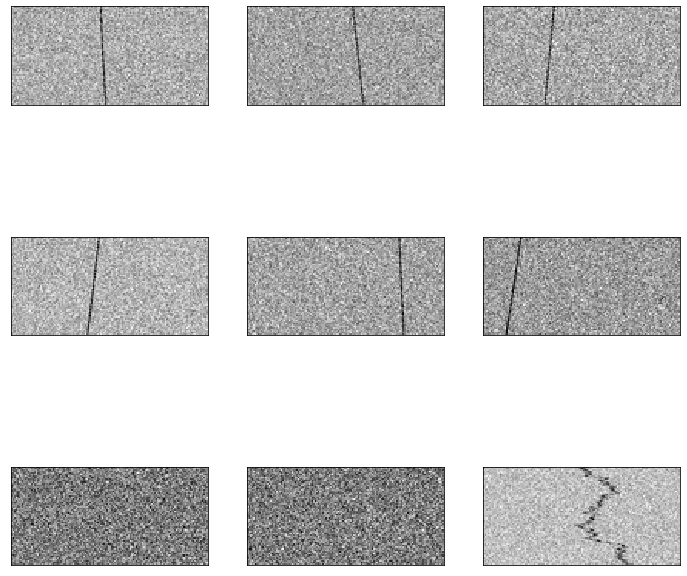

In [20]:
plt.figure(0,figsize=(12,12))
for i in range(1,10):
    plt.subplot(3,3,i)
    image = np.squeeze(x_train[np.random.randint(0,3200)])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image,cmap='gray')

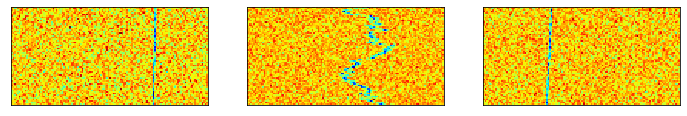

In [21]:
plt.figure(0,figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    image = np.squeeze(x_train[np.random.randint(0,3200)])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image,cmap='jet')

##  Create Training and Validation Data Generators

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)

In [23]:
datagen_train.fit(x_train)
datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

##  Creating the CNN Model

In [24]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
# Initialising the CNN
model = Sequential()
# 1st Convolution
model.add(Conv2D(32,(5,5),padding='same',input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# 2nd Convolution layer
model.add(Conv2D(64,(5,5),padding='same',input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
# final prediction layer
model.add(Dense(4,activation='softmax'))


##  Learning Rate Scheduling and Compile the Model

In [33]:
initial_learning  = 0.005
lr_schedule =  tf.keras.optimizers.schedules.ExponentialDecay( initial_learning_rate = initial_learning,decay_rate = 0.96,decay_steps = 5, staircase = True)

In [34]:
optimizer = Adam(learning_rate = lr_schedule)

In [49]:
model.compile(optimizer= optimizer,metrics=['accuracy'],loss='categorical_crossentropy')

##  Training the Model

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_3 (Activation)    (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 64, 64)       

In [37]:
checkpoint = ModelCheckpoint('weights.h5',monitor = 'val_loss',save_weights_only = True, mode= 'min', verbose = 0)

In [38]:
callbacks = [PlotLossesCallback,checkpoint]

In [39]:
batch_size = 32

In [50]:
history = model.fit_generator(datagen_train.flow(x_train,y_train,shuffle=True,batch_size=batch_size),
                   steps_per_epoch = len(x_train)//batch_size,
                   validation_data= datagen_val.flow(x_val,y_val,shuffle=True,batch_size=batch_size),
                   validation_steps = len(x_val)//batch_size,
                   epochs=10
                   callbacks=[checkpoint]
                   )

Epoch 1/10
100/100 [==============================] - 134s 1s/step - loss: 0.5658 - accuracy: 0.7022 - val_loss: 3.5937 - val_accuracy: 0.2500
Epoch 2/10
100/100 [==============================] - 154s 2s/step - loss: 0.3875 - accuracy: 0.7462 - val_loss: 4.2886 - val_accuracy: 0.2637
Epoch 3/10
100/100 [==============================] - 144s 1s/step - loss: 0.3850 - accuracy: 0.7506 - val_loss: 3.9104 - val_accuracy: 0.2512
Epoch 4/10
100/100 [==============================] - 147s 1s/step - loss: 0.3796 - accuracy: 0.7469 - val_loss: 2.6908 - val_accuracy: 0.4737
Epoch 5/10
100/100 [==============================] - 148s 1s/step - loss: 0.3761 - accuracy: 0.7491 - val_loss: 2.8038 - val_accuracy: 0.4950
Epoch 6/10
100/100 [==============================] - 144s 1s/step - loss: 0.3785 - accuracy: 0.7462 - val_loss: 2.5787 - val_accuracy: 0.5013
Epoch 7/10
100/100 [==============================] - 151s 2s/step - loss: 0.3662 - accuracy: 0.7506 - val_loss: 1.1852 - val_accuracy: 0.5638

## Task 8: Model Evaluation

In [51]:
model.evaluate(x_val,y_val)

25/25 [==============================] - 6s 257ms/step - loss: 0.3742 - accuracy: 0.7500


[0.3741598427295685, 0.75]

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val,1)
y_pred = np.argmax(model.predict(x_val),1)

In [54]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       200
           1       0.51      0.41      0.46       200
           2       0.51      0.62      0.56       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



In [55]:
print(metrics.accuracy_score(y_true,y_pred))

0.75


In [ ]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]
